In [ ]:
!pip install arviz

In [2]:
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import random
import arviz as az
import theano as tt

MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 

You can download it from here

https://osf.io/jda6s/

In [4]:
!wget https://osf.io/jda6s/download

--2020-10-08 21:39:25--  https://osf.io/jda6s/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/8uxpv/providers/osfstorage/58488b3a594d9001fa6debdf?action=download&direct&version=1 [following]
--2020-10-08 21:39:25--  https://files.osf.io/v1/resources/8uxpv/providers/osfstorage/58488b3a594d9001fa6debdf?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55440440 (53M) [application/octet-stream]
Saving to: ‘download’

download            100%[===================>]  52.87M  79.3MB/s    in 0.7s    

2020-10-08 21:39:27 (79.3 MB/s) - ‘download’ saved [55440440/55440440]



In [ ]:
mnist = loadmat("../datasets/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

In [ ]:
mnist_label

array([0., 0., 0., ..., 9., 9., 9.])

In [ ]:
## We only consider two digits to perform binary classification and only use 100 instances
#per digit to make learning faset
np.random.seed(0)
digits = [5,8]
N_per_digit =500
X = []
labels = []
for d in digits:
    imgs = mnist_data[np.where(mnist_label==d)[0],:]
    X.append(imgs[np.random.permutation(imgs.shape[0]),:][0:N_per_digit,:])
    labels.append(np.ones(N_per_digit)*d)
X = np.vstack(X).astype(np.float64)
y = np.hstack(labels)
X = X / 255.0
y = np.where(y==5,1,0)#class 3 ->1, class 8->0

In [ ]:
X.shape

(1000, 784)

In [ ]:
## Split data in training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [ ]:
X_train.shape

(850, 784)

## SKlearn  Logistic regression

In [ ]:
clf = LogisticRegression(random_state=0, C=900, max_iter=2000, solver='lbfgs').fit(X_train, y_train)
y_pred_LR = clf.predict(X_test)
y_pred_prob_LR = clf.predict_proba(X_test)[:,1]#class 1 probability
print(y_pred_LR[0:3])
print("Accuracy=",accuracy_score(y_pred_LR,y_test))

[0 0 1]
Accuracy= 0.9


In [ ]:
import pymc3 as pm
#be sure that the
with pm.Model() as logistic_model:     
    alpha= pm.Normal('alpha', 0.0, sd=30)
    beta = pm.Normal('beta', 0.0, sd=30, shape=(X_train.shape[1],)) #
    phi = pm.Deterministic('phi', pm.math.invlogit(alpha+pm.math.dot(X_train, beta)))#logistic function 
    #tt.printing.Print('alpha_ls')(phi)
    likelihood = pm.Bernoulli('likelihood', phi, observed=y_train)
    


Average Loss = 1,601: 100%|██████████| 100000/100000 [02:34<00:00, 646.69it/s] 
Finished [100%]: Average Loss = 1,601.1


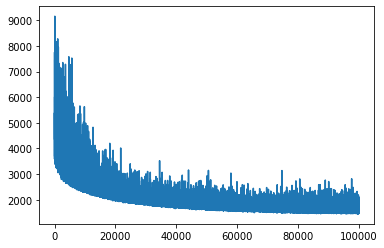

In [ ]:
with logistic_model:
    approximation = pm.fit(100000,method='advi')#50000 are the number of iterations of the algorithms
    
plt.plot(approximation.hist);
posterior = approximation.sample(5000)#we sample 500000 samples from the posterior


In [ ]:
#sampled probability of class 1
y_pred_proba_Bayes_samples = 1/(1+np.exp(-posterior['alpha'].T-np.dot(X_test,posterior['beta'].T)))#proba class 1
#mean of the samples probablities
y_pred_proba_Bayes=np.mean(y_pred_proba_Bayes_samples,axis=1)
threshold=0.5
#class predicted
y_pred_B=np.where(y_pred_proba_Bayes>threshold,1,0)
print("Testing accuracy: ")
print(accuracy_score(y_test,y_pred_B))

Testing accuracy: 
0.9041666666666667


In [ ]:
y_pred_samples=np.where(y_pred_proba_Bayes_samples>threshold,1,0)
uncertainty=np.std(y_pred_samples,axis=1)

Text(0, 0.5, 'STD of the predicted class')

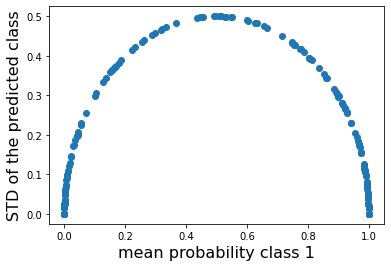

In [ ]:
plt.scatter(y_pred_proba_Bayes,uncertainty)
ind_wrong=np.where(y_test!=y_pred_B)[0]
plt.xlabel("mean probability class 1", fontsize=16)
plt.ylabel("STD of the predicted class", fontsize=16)

Text(0, 0.5, 'STD of the predicted class')

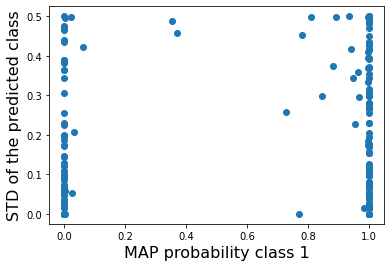

In [ ]:
plt.scatter(y_pred_prob_LR,uncertainty)
plt.xlabel("MAP probability class 1", fontsize=16)
plt.ylabel("STD of the predicted class", fontsize=16)

Text(0, 0.5, 'STD of the predicted class')

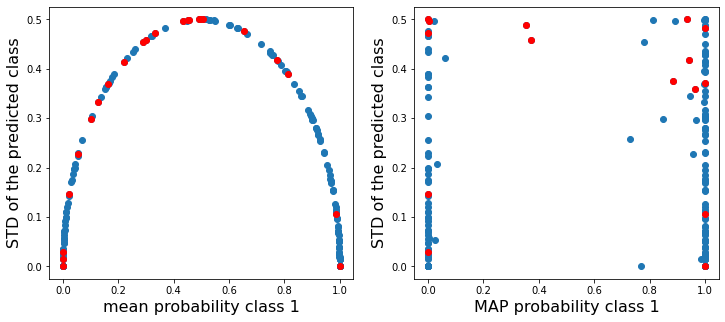

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(y_pred_proba_Bayes,uncertainty)
ind_wrong=np.where(y_test!=y_pred_B)[0]
plt.scatter(y_pred_proba_Bayes[ind_wrong],uncertainty[ind_wrong],color='r')
plt.xlabel("mean probability class 1", fontsize=16)
plt.ylabel("STD of the predicted class", fontsize=16)
plt.subplot(122)
plt.scatter(y_pred_prob_LR,uncertainty)
ind_wrong=np.where(y_test!=y_pred_LR)[0]
plt.scatter(y_pred_prob_LR[ind_wrong],uncertainty[ind_wrong],color='r')
plt.xlabel("MAP probability class 1", fontsize=16)
plt.ylabel("STD of the predicted class", fontsize=16)